<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichilet-Network/blob/main/dirichlet_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Utility.py File
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import torch.distributions as dist
from mpl_toolkits import mplot3d
from torch.distributions.dirichlet import Dirichlet

from scipy.stats import multivariate_normal
from scipy.stats import norm

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import multivariate_normal
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import multivariate_normal
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:

def plot_dir(alpha, size):
  model = Dirichlet(torch.tensor(alpha))
  sample = model.sample(torch.Size([size])).data
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(sample[:, 0], sample[:, 1], sample[:, 2], color='red')
  ax.plot([0, 0], [1, 0], [0, 1], linewidth=3, color='purple')
  ax.plot([0, 1], [0, 0], [1, 0], linewidth=3, color='purple')
  ax.plot([0, 1], [1, 0], [0, 0], linewidth=3, color='purple')
  ax.set_xlim((0, 1))
  ax.set_ylim((0, 1))
  ax.set_zlim((0, 1))
  ax.view_init(60, 35)


def numpy_to_tensor(arr):
  ret = torch.Tensor([arr])
  return ret

In [3]:
def target_alpha(targets):
  target = targets.numpy()
  def gen_onehot(category, total_cat=10):
    label = np.ones(total_cat)
    label[category] = 20
    return label
  target_alphas = []
  for i in target:
    if i==10:
      target_alphas.append(torch.tensor(np.ones(10)))
    else:
      target_alphas.append(torch.tensor(gen_onehot(i)))
  return torch.stack(target_alphas)

In [4]:
class PriorNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)         # output_dim = 4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)

    def predict_alpha(self, x):
      src = torch.Tensor([x]).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))
    
    def expected_entropy_from_alphas(self, alphas, alpha0):
        return -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
    
    def categorical_entropy_torch(self, probs):
        log_probs = torch.log(probs)
        log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
        entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
        return entropy

    def mutual_information(self, x):
        
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0

        expected_entropy = self.expected_entropy_from_alphas(alphas, alpha0)
        entropy_of_exp = self.categorical_entropy_torch(probs)
        mutual_info = entropy_of_exp - expected_entropy
        return mutual_info

    def diffenrential_entropy(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

    def entropy(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret


In [5]:
class PriorNet_CNN(PriorNet):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

    def fit(self, epoch_num, optimizer, train_all):
      self.train()

      # Shuffle the input
      train_loader = torch.utils.data.DataLoader(train_all, 
                                                 batch_size=32, 
                                                 shuffle=True)

      for epoch in range(epoch_num):
        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):

          optimizer.zero_grad()

          data = data.to(device)

          # predict alpha
          target_a = target_alpha(target)
          target_a = target_a.to(device)
          output_alpha = torch.exp(self.forward(data))
          dirichlet1 = Dirichlet(output_alpha)
          dirichlet2 = Dirichlet(target_a)

          loss = torch.sum(dist.kl.kl_divergence(dirichlet1, dirichlet2))
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss_total/120000))
    
    def max_prob(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values


In [6]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

    def fit(self, optimizer, epoch):
      train_in = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                      transform=torchvision.transforms.Compose(
                                          [torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize(
                                                        (0.1307,), (0.3081,))]))
      train_loader = torch.utils.data.DataLoader(train_in, batch_size=64, shuffle=True)
      self.train()
      for epoch_num in range(epoch):
        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()

          data = data.to(device)
          target = target.to(device)

          output = self.forward(data)
          loss = F.nll_loss(output, target)
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch_num, loss_total/120000))
        

    def test(self):
      self.eval()
      test_loss = 0
      correct = 0
      test_loader = torch.utils.data.DataLoader(test_in, batch_size=64, shuffle=True)
      with torch.no_grad():
        for data, target in test_loader:

          data = data.to(device)
          target = target.to(device)

          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)

      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
      )

    def predict_alpha(self, x):
      self.eval()
      src = torch.Tensor([x]).to(device)
      output = torch.exp(self.forward(src))
      return output

    def max_prob(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values

    def entropy(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret


In [7]:
train_in = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,)),
                                             ]))

test_in = torchvision.datasets.MNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,)),
                                             ]))
train_out = torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,))]))
test_out = torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



In [8]:
train_out.targets = torch.tensor(np.ones(len(train_out.targets))*10, dtype=torch.long)
test_out.targets = torch.tensor(np.ones(len(test_out.targets))*10, dtype=torch.long)

train_all = train_in
train_all.data = torch.cat((train_in.data, train_out.data))
train_all.targets = torch.cat((train_in.targets, train_out.targets))


In [ ]:
dpn = PriorNet_CNN()
if torch.cuda.is_available(): dpn.cuda()
optimizer = optim.Adam(dpn.parameters(), lr=0.001)

dpn.fit(30, optimizer, train_all)

Train Epoch: 0 	 Loss: 5.469186
Train Epoch: 1 	 Loss: 3.990394
Train Epoch: 2 	 Loss: 3.665732
Train Epoch: 3 	 Loss: 3.472477
Train Epoch: 4 	 Loss: 3.384507
Train Epoch: 5 	 Loss: 3.302465
Train Epoch: 6 	 Loss: 3.253852
Train Epoch: 7 	 Loss: 3.211014
Train Epoch: 8 	 Loss: 3.203044
Train Epoch: 9 	 Loss: 3.192186
Train Epoch: 10 	 Loss: 3.152454
Train Epoch: 11 	 Loss: 3.143881
Train Epoch: 12 	 Loss: 3.114620
Train Epoch: 13 	 Loss: 3.136309
Train Epoch: 14 	 Loss: 3.121062
Train Epoch: 15 	 Loss: 3.117411
Train Epoch: 16 	 Loss: 3.099944
Train Epoch: 17 	 Loss: 3.092566
Train Epoch: 18 	 Loss: 3.076810
Train Epoch: 19 	 Loss: 3.089536
Train Epoch: 20 	 Loss: 3.058402
Train Epoch: 21 	 Loss: 3.074306
Train Epoch: 22 	 Loss: 3.067185
Train Epoch: 23 	 Loss: 3.069371
Train Epoch: 24 	 Loss: 3.069470
Train Epoch: 25 	 Loss: 3.047786
Train Epoch: 26 	 Loss: 3.045963
Train Epoch: 27 	 Loss: 3.058162
Train Epoch: 28 	 Loss: 3.034081
Train Epoch: 29 	 Loss: 3.035723


In [18]:
dnn = DNN()
if torch.cuda.is_available(): dnn.cuda()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)

dnn.test()
dnn.fit(optimizer, 30)
dnn.test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3132, Accuracy: 1400/10000 (14%)

Train Epoch: 0 	 Loss: 0.004253
Train Epoch: 1 	 Loss: 0.001964
Train Epoch: 2 	 Loss: 0.001637
Train Epoch: 3 	 Loss: 0.001450
Train Epoch: 4 	 Loss: 0.001339
Train Epoch: 5 	 Loss: 0.001247
Train Epoch: 6 	 Loss: 0.001201
Train Epoch: 7 	 Loss: 0.001130
Train Epoch: 8 	 Loss: 0.001090
Train Epoch: 9 	 Loss: 0.001036
Train Epoch: 10 	 Loss: 0.001040
Train Epoch: 11 	 Loss: 0.001013
Train Epoch: 12 	 Loss: 0.000979
Train Epoch: 13 	 Loss: 0.000997
Train Epoch: 14 	 Loss: 0.000946
Train Epoch: 15 	 Loss: 0.000909
Train Epoch: 16 	 Loss: 0.000916
Train Epoch: 17 	 Loss: 0.000887
Train Epoch: 18 	 Loss: 0.000854
Train Epoch: 19 	 Loss: 0.000878
Train Epoch: 20 	 Loss: 0.000885
Train Epoch: 21 	 Loss: 0.000852
Train Epoch: 22 	 Loss: 0.000838
Train Epoch: 23 	 Loss: 0.000857
Train Epoch: 24 	 Loss: 0.000817
Train Epoch: 25 	 Loss: 0.000846
Train Epoch: 26 	 Loss: 0.000830
Train Epoch: 27 	 Loss: 0.000808
Train Epoch: 28 	 Loss: 0.00

In [19]:
# miscood.py

def uncertainty_score(model, test_data, metrics):
  model.eval()
  score_lst = []
  for x in test_data:
    x = [x]
    with torch.no_grad():
      if metrics=='DE':
        score = model.diffenrential_entropy(x).data.cpu().numpy()[0][0]
      elif metrics=='MI':
        score = model.mutual_information(x).data.cpu().numpy()[0]
      elif metrics=='MAXP':
        score = model.max_prob(x).data.cpu().numpy()[0]
      elif metrics=='ENT':
        score = model.entropy(x).data.cpu().numpy()[0]
    score_lst.append(score)
  return score_lst


def get_ood_label_score(test_in_score, test_out_score):
  score = np.concatenate([test_in_score, test_out_score])
  label = np.concatenate((np.zeros(len(test_in_score)), np.ones(len(test_out_score))))
  return label, score
  
def get_misc_label_score(model, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
    x = [x]
    with torch.no_grad():
      pred = model.predict_alpha(x)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(test_label[i], pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

def plot_roc(label, score, label_name):
  fpr, tpr, thresholds = roc_curve(label, score)
  plt.plot(fpr, tpr, label=label_name)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)

def plot_pr(label, score, label_name):
  precision, recall, thresholds = precision_recall_curve(label, score)
  plt.plot(recall, precision, label=label_name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)


def get_auroc_aupr(label, score):
  #score[score==-np.inf] = -100
  #score[score==np.inf] = 100

  auroc = roc_auc_score(label, score)
  precision, recall, thresholds = precision_recall_curve(label, score)
  aupr = auc(recall, precision)
  return auroc, aupr


def get_test_roc_pr(network, metrics, detect='ood'):
  test_in_score = uncertainty_score(network, test_in.data.numpy(), metrics)
  test_out_score = uncertainty_score(network, test_out.data.numpy(), metrics)
  if detect=='ood':
    label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
  elif detect=='misc':
    label_dp, score_dp = get_misc_label_score(network, test_in.data.numpy(),
                                              test_in.targets, test_in_score)
  if metrics=='MAXP':
    score_dp = -score_dp

  index = np.isposinf(score_dp)
  score_dp[np.isposinf(score_dp)] = 1e9
  maximum = np.amax(score_dp)
  score_dp[np.isposinf(score_dp)] = maximum + 1

  index = np.isneginf(score_dp)
  score_dp[np.isneginf(score_dp)] = -1e9
  minimum = np.amin(score_dp)
  score_dp[np.isneginf(score_dp)] = minimum - 1

  score_dp[np.isnan(score_dp)] = 0

  auroc, aupr = get_auroc_aupr(label_dp, score_dp)
  return auroc, aupr, label_dp, score_dp

In [ ]:
auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


In [ ]:
auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.708179,0.707324,0.664459,0.478972
AUPR,0.640995,0.635807,0.602640,0.389682


ROC curve for DPN

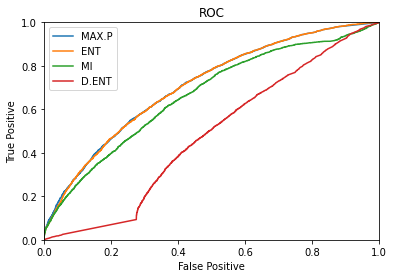

In [ ]:
plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

Precision-Recall for DPN

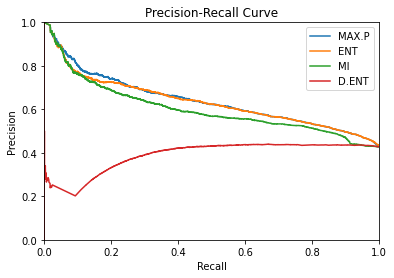

In [ ]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

**DNN**

In [20]:
auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'misc')
auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'misc')

auroc_lst = [auroc_mp, auroc_ent]
aupr_lst = [aupr_mp, aupr_ent]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent'], 
             index=['AUROC', 'AUPR'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


,Max.P,Ent
AUROC,0.561113,0.50000
AUPR,0.357838,0.53115


In [22]:
from google.colab import drive
drive.mount('/content/drive')
model_save_name_dpn = 'dpn.pt'
path_dpn = F"/content/drive/MyDrive/{model_save_name_dpn}" 
# torch.save(dpn.state_dict(), path_dpn)

model_save_name_dnn = 'dnn.pt'
path_dnn = F"/content/drive/MyDrive/{model_save_name_dnn}" 
torch.save(dnn.state_dict(), path_dnn)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# dpn.save('/content/drive/MyDrive/dpn_entire.pt')
torch.save(dnn, '/content/drive/MyDrive/dnn_entire.pt')